In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
rng = np.random.RandomState(20170720)
data = pd.read_csv('data.csv')

n_bootstrap = 10000
repetitions = 1000

In [3]:
state_black = data['Fraction Black'].values
state_woman = data['Fraction Female'].values

### This is slow for a lot of bootstraps and repetitions. Code that can run on GPUs with Theano is below.

In [ ]:
n_states_2_women = np.empty(n_bootstrap * repetitions, dtype='uint8')
n_black_women = np.empty(n_bootstrap * repetitions, dtype='uint8')
n_black = np.empty(n_bootstrap * repetitions, dtype='uint8')
n_women = np.empty(n_bootstrap * repetitions, dtype='uint8')

for ii in range(repetitions):
    print('{} out of {}'.format(ii, repetitions))
    senate_woman = rng.rand(n_bootstrap, 50, 2) < state_woman[np.newaxis, :, np.newaxis]
    senate_black = rng.rand(n_bootstrap, 50, 2) < state_black[np.newaxis, :, np.newaxis]
    both_women_per_state = senate_woman[..., 0] * senate_woman[..., 1]
    n_state_2_women[ii*n_bootstrap:(ii+1)*n_bootstrap] = both_women_per_state.sum(axis=1)
    n_black_women[ii*n_bootstrap:(ii+1)*n_bootstrap] = np.sum(senate_woman * senate_black, axis=(1, 2))
    n_black[ii*n_bootstrap:(ii+1)*n_bootstrap] = senate_black.sum(axis=(1, 2))
    n_women[ii*n_bootstrap:(ii+1)*n_bootstrap] = senate_woman.sum(axis=(1, 2))

# Plot

In [9]:
def make_plots(data, reality, description):
    f, axes = plt.subplots(1, 2, figsize=(10, 5))
    for ax in axes:
        h, b, p = ax.hist(data, bins=np.arange(0, 101), normed=True)
        ax.plot([reality + .5, reality + .5], [0, 1], c='black')
        ax.set_ylim(h[h>0].min()/10., 1)
        ax.set_xlim(-1, data.max() + 2)
        ax.set_xlabel('Number of {}'.format(description))
        ax.set_ylabel('Probability')
    axes[0].set_ylim(0, .2)
    axes[0].set_yticks([0, .1, .2])
    axes[1].set_yscale('log')
    print('p for {} or fewer {}: {}'.format(reality, description, np.mean(data <= reality)))
    print('mean for {}: {}'.format(description, data.mean()))
    print('mode for {}: {} at {} probability'.format(description, h.argmax(), h.max()))

p for 1 or fewer Black women senators: 0.0263656
mean for Black women senators: 5.279113
mode for Black women senators: 5 at 0.1828155 probability


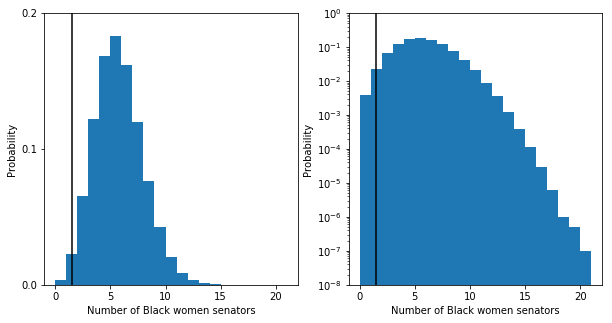

In [21]:
make_plots(n_black_women, 1, 'Black women senators')
plt.savefig(os.path.join(os.environ['HOME'],'Downloads/1BlackWoman.png'), dpi=300)
plt.show()

p for 3 or fewer Black senators: 0.0043004
mean for Black senators: 10.3405284
mode for Black senators: 10 at 0.1377432 probability


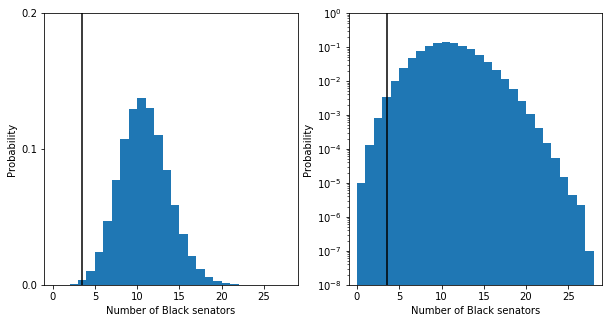

In [22]:
make_plots(n_black, 3, 'Black senators')
plt.savefig(os.path.join(os.environ['HOME'],'Downloads/3Black.png'), dpi=300)
plt.show()

p for 3 or fewer states with 2 women senators: 0.0003426
mean for states with 2 women senators: 12.8569004
mode for states with 2 women senators: 13 at 0.1276618 probability


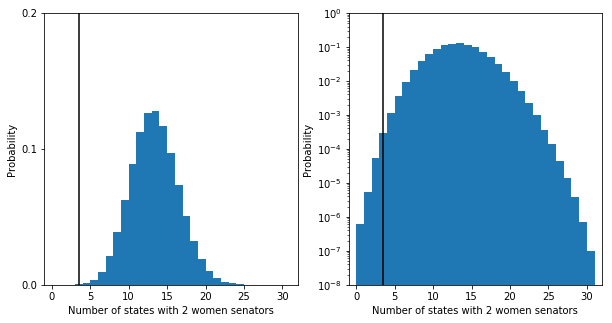

In [20]:
make_plots(n_states_2_women, 3, 'states with 2 women senators')
plt.savefig(os.path.join(os.environ['HOME'],'Downloads/2WomenStates.png'), dpi=300)
plt.show()

p for 21 or fewer women senators: 6e-10
mean for women senators: 50.7000268405
mode for women senators: 51 at 0.0794677166 probability


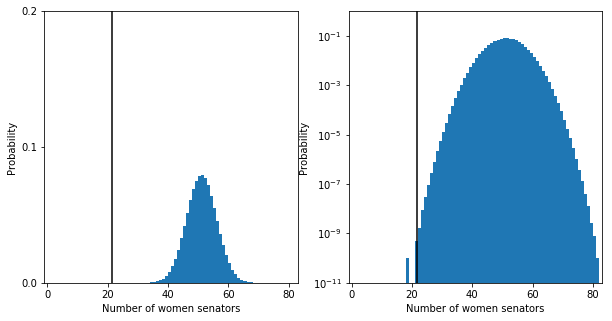

In [10]:
make_plots(n_women, 21, 'women senators')
plt.savefig(os.path.join(os.environ['HOME'],'Downloads/21Women.png'), dpi=300)
plt.show()

# Coins 

In [40]:
def factorial(n):
    """Compute n!."""
    result = 1
    for ii in range(1, n+1):
        result *= ii
    return result

def odds(n, h):
    """Compute the odds of getting h heads in n coin-flips."""
    return .5**n * (factorial(n))/(factorial(n-h))/(factorial(h))

In [50]:
print(odds(10, 5))
print(odds(10, 7))

0.24609375
0.1171875


In [51]:
print(odds(100, 50))
print(odds(100, 70))

0.07958923738717878
2.3170690580135177e-05


In [52]:
(factorial(100))/(factorial(100-21))/(factorial(21))

2.0418414110621324e+21

# Faster sampling (requires theano)

In [4]:
import theano
import theano.tensor as T
from theano.sandbox import rng_mrg

Using cuDNN version 5105 on context None
Mapped name None to device cuda0: GeForce GTX 780 (0000:01:00.0)


In [5]:
n_bootstrap = 100000
repetitions = 100

In [6]:
sw = theano.shared(state_woman.astype('float32'))
sb = theano.shared(state_black.astype('float32'))

t_rng = rng_mrg.MRG_RandomStreams(20170720)
ru_w = t_rng.uniform((n_bootstrap, 50, 2))
ru_b = t_rng.uniform((n_bootstrap, 50, 2))

senate_woman = T.switch(ru_w < sw.dimshuffle('x', 0, 'x'), 1., 0.)
senate_black = T.switch(ru_b < sb.dimshuffle('x', 0, 'x'), 1., 0.)
both_women_per_state = senate_woman[:, :, 0] * senate_woman[:, :, 1]
black_woman = senate_woman * senate_black
n_states_2_women = both_women_per_state.sum(axis=1)
n_black_women = black_woman.sum(axis=(1, 2))
n_black = senate_black.sum(axis=(1, 2))
f = theano.function([], [n_states_2_women, n_black_women, n_black])

In [8]:
n_states_2_women = np.empty(n_bootstrap * repetitions, dtype='uint8')
n_black_women = np.empty(n_bootstrap * repetitions, dtype='uint8')
n_black = np.empty(n_bootstrap * repetitions, dtype='uint8')

for ii in range(repetitions):
    ns2w, nbw, nb = [x.astype('uint8') for x in f()]
    n_state_2_women[ii*n_bootstrap:(ii+1)*n_bootstrap] = ns2w
    n_black_women[ii*n_bootstrap:(ii+1)*n_bootstrap] = nbw
    n_black[ii*n_bootstrap:(ii+1)*n_bootstrap] = nb

# Number of women

In [5]:
n_bootstrap = 1000000
repetitions = 10000

In [6]:
sw = theano.shared(state_woman.astype('float32'))

t_rng = rng_mrg.MRG_RandomStreams(20170720)
ru_w = t_rng.uniform((n_bootstrap, 50, 2))

senate_woman = T.switch(ru_w < sw.dimshuffle('x', 0, 'x'), 1., 0.)
n_women = senate_woman.sum(axis=(1, 2))
f = theano.function([], n_women)

In [ ]:
n_women = np.empty(n_bootstrap * repetitions, dtype='uint8')
for ii in range(repetitions):
    n_women[ii*n_bootstrap:(ii+1)*n_bootstrap] = f().astype('uint8')